In [2]:
%matplotlib inline

import jax.numpy as jnp
from jax import value_and_grad
from jax import random
from scipy.optimize import minimize
from jax.random import PRNGKey
import matplotlib.pyplot as plt
import seaborn as snb


from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar(im, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')


# we want to use 64 bit floating precision
import jax
jax.config.update("jax_enable_x64", True)

snb.set_style('darkgrid')
snb.set_theme(font_scale=1.25)


## Task 2.1


(100, 2)


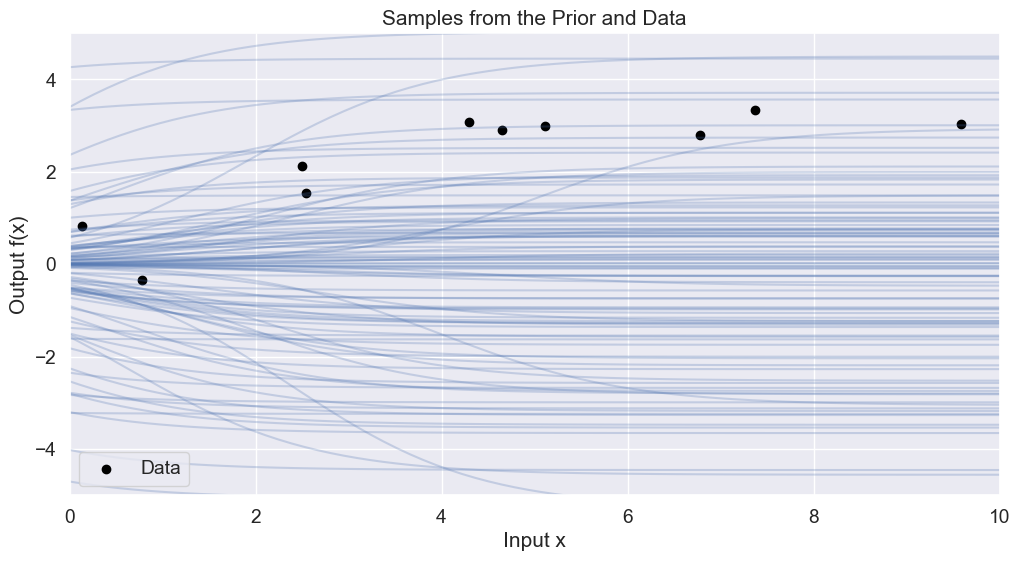

In [3]:
key = PRNGKey(0)
N = 10 
X = jnp.array([9.589, 7.375, 4.647, 2.501, 2.538, 6.783, 4.294, 5.111, 0.130, 0.783]).ravel()
y = jnp.array([3.032, 3.349, 2.906, 2.126, 1.538, 2.787, 3.078, 2.993, 0.828,-0.331]).ravel()

tau, beta = 2, 4


## TASK 2.1 ##
f = lambda w, x: w[1] / (1 + jnp.exp(-(x + w[0]) ) )

S = 100  #num of samples
mean = jnp.array([0, 0])

cov = jnp.array([[tau ** 2, 0],
                 [0, tau ** 2]])

w_samples = random.multivariate_normal(key,
                                       mean,
                                       cov,
                                       shape=(100,))

x_samples = jnp.linspace(-2, 12, 100)

f_samples = [f(w_samples[i], x_samples) for i in range(0,S)]


fig, ax = plt.subplots(1,1, figsize=(12,6))
for i in range(S):
    plt.plot(x_samples, f_samples[i], color= "b", alpha= 0.25)
ax.scatter(X, y, color="black", label="Data")
ax.set(xlabel="Input x", ylabel="Output f(x)")
ax.legend()
ax.set_xlim(0, 10)
ax.set_ylim(-5,5)
plt.title("Samples from the Prior and Data")
plt.grid(True)


zz= w_samples[0]
print(w_samples.shape)

## Task 2.3

In [4]:
log_npdf = lambda x, m, v: -0.5 * jnp.log(2 * jnp.pi * v) - 0.5 * (x - m) ** 2 / v

def log_joint(w, x, y):
    a = log_npdf(w[0], 0, tau ** 2)
    b = log_npdf(w[1], 0, tau ** 2)
    c = jnp.sum( log_npdf(y, f(w,x), beta ** -1))
    return a + b + c

w = jnp.array([0,0])
log_joint(w, X, y)

Array(-130.94934095, dtype=float64)

In [5]:
# Simplified expression of the log joint for w= [0,0], just to double check the result
-jnp.log(2 * jnp.pi * tau ** 2)- 5*jnp.log(jnp.pi / 2)  -2*jnp.sum(y **2 )

Array(-130.94934095, dtype=float64)

In [35]:
from jax import grad, hessian
import jax.numpy as jnp
from scipy.optimize import minimize
import numpy as np
from jax import random


# your sigmoid-based model
sigma = lambda x: 1 / (1 + jnp.exp(-x))
f = lambda w, x: w[1] * sigma(x + w[0])

# provided log normal density
log_npdf = lambda x, m, v: -0.5 * jnp.log(2 * jnp.pi * v) - 0.5 * (x - m) ** 2 / v

# full log joint density
def log_joint(w, x, y):
    a = log_npdf(w[0], 0, tau ** 2)
    b = log_npdf(w[1], 0, tau ** 2)
    c = jnp.sum(log_npdf(y, f(w, x), 1 / beta))
    return a + b + c

# grad and hess of log_joint
grad_log_joint = grad(log_joint)
hess_log_joint = hessian(log_joint)

# convert to numpy-friendly functions
def neg_log_joint_np(w_np):
    return -float(log_joint(jnp.array(w_np), X, y))

def grad_neg_log_joint_np(w_np):
    return -np.array(grad_log_joint(jnp.array(w_np), X, y))

# initial guess
w0 = np.zeros(2)

# minimize
res = minimize(neg_log_joint_np, w0, jac=grad_neg_log_joint_np)
w_map = res.x

print("MAP estimate: ", w_map)


MAP estimate:  [-2.20442705  3.10426822]


In [36]:
H = -hess_log_joint(jnp.array(w_map), X, y)
H_inv = jnp.linalg.inv(H)

print("Hessian: ", H)
print("Hessian inverse: ", H_inv)

Hessian:  [[ 7.85402077  6.89708646]
 [ 6.89708646 25.14344258]]
Hessian inverse:  [[ 0.16772658 -0.046009  ]
 [-0.046009    0.05239251]]


In [38]:
# Sigmoid and derivative
sigma = lambda x: 1 / (1 + jnp.exp(-x))
sigma_prime = lambda x: sigma(x) * (1 - sigma(x))
sigma_double_prime = lambda x: (1 - 2 * sigma(x)) * sigma_prime(x)

def manual_hessian(w, x, y, tau, beta):
    w0, w1 = w
    z = x + w0
    s = sigma(z)
    s_prime = sigma_prime(z)
    s_double_prime = sigma_double_prime(z)

    residuals = y - w1 * s

    h00 = -1 / tau**2 + beta * jnp.sum(
        - (w1 * s_prime) ** 2 + residuals * w1 * s_prime * (1 - 2 * s)
    )
    h11 = -1 / tau**2 - beta * jnp.sum(s ** 2)
    h01 = beta * jnp.sum( sigma_prime(z) * (y - 2.0 * w1 * s) )


    H = jnp.array([
        [h00, h01],
        [h01, h11]
    ])
    return H

H_manual = manual_hessian(w_map, X, y, tau=2.0, beta=4.0)
print(-H_manual)

[[ 7.85402077  6.89708646]
 [ 6.89708646 25.14344258]]


In [42]:
H_jax = hessian(log_joint)(jnp.array(w_map), X, y)
H_manual = manual_hessian(w_map, X, y, tau=2.0, beta=4.0)

print("Manual Hessian:\n", H_manual)
print("JAX Hessian (negated):\n", H_jax)
print("Difference:\n", H_manual - H_jax)

Manual Hessian:
 [[ -7.85402077  -6.89708646]
 [ -6.89708646 -25.14344258]]
JAX Hessian (negated):
 [[ -7.85402077  -6.89708646]
 [ -6.89708646 -25.14344258]]
Difference:
 [[0. 0.]
 [0. 0.]]


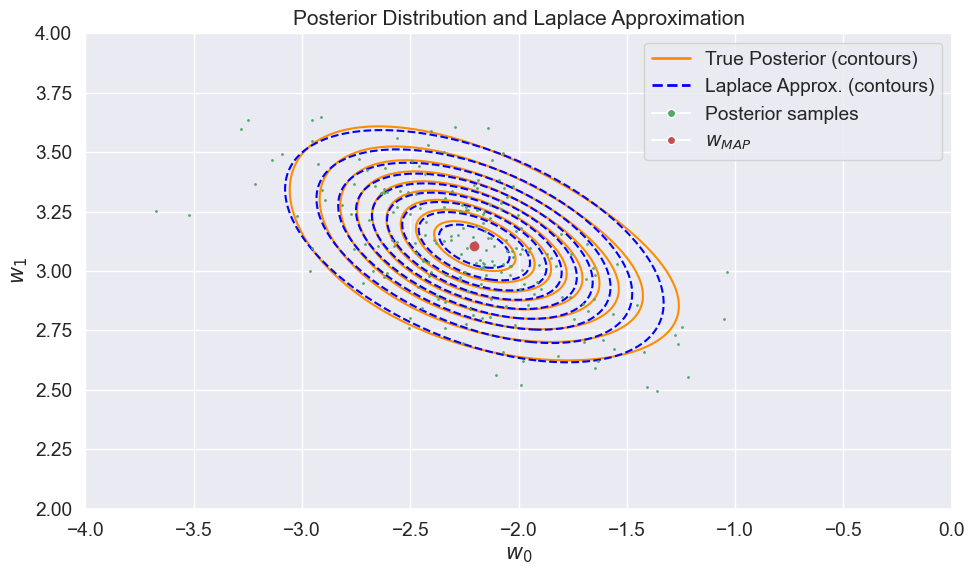

In [43]:
from jax import random
from scipy.stats import multivariate_normal as mvn_scipy
import matplotlib.pyplot as plt


# --- MODEL CLASS ---
class LogisticRegression:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.D = 2  # dimensionality

        def neg_log_joint_np(w_np):
            return -float(log_joint(jnp.array(w_np), self.X, self.y))

        def grad_neg_log_joint_np(w_np):
            return -np.array(grad(log_joint)(jnp.array(w_np), self.X, self.y))

        w0 = np.zeros(self.D)
        res = minimize(neg_log_joint_np, w0, jac=grad_neg_log_joint_np)
        self.w_MAP = res.x
        self.hessian = lambda w: hessian(log_joint)(w, self.X, self.y)
        self.log_joint = lambda w: log_joint(w, self.X, self.y)

class LaplaceApproximation:
    def __init__(self, model):
        """ implements a laplace approximation q(w) = N(m, S) """
        self.model = model
        self.posterior_mean = model.w_MAP                               
        self.posterior_hessian = model.hessian(model.w_MAP)             
        self.posterior_cov = -jnp.linalg.inv(self.posterior_hessian)     

        # sanity checks
        assert self.posterior_mean.shape == (model.D,)
        assert self.posterior_hessian.shape == (model.D, model.D)
        assert self.posterior_cov.shape == (model.D, model.D)

    def log_pdf(self, w):
        """ evaluate approximate posterior density at w """
        return mvn_scipy.logpdf(w, self.posterior_mean, self.posterior_cov)

    def posterior_samples(self, key, num_samples):
        """ generate samples from posterior distribution """
        return random.multivariate_normal(key, self.posterior_mean, self.posterior_cov, shape=(num_samples,))

# --- RUN EVERYTHING ---
model = LogisticRegression(X, y)
laplace = LaplaceApproximation(model)

# --- SAMPLE FROM POSTERIOR ---
key = random.PRNGKey(1)
w_samples = laplace.posterior_samples(key, 200)

# --- CREATE GRID ---
dim1 = np.linspace(-4,0 , 200)
dim2 = np.linspace(2, 4, 200)
xx, yy = np.meshgrid(dim1, dim2)
grid = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)

# --- TRUE POSTERIOR ---
log_post_vals = jnp.array([model.log_joint(w) for w in grid])
post_vals = jnp.exp(log_post_vals - jnp.max(log_post_vals))
post_vals = post_vals.reshape(xx.shape)

# --- LAPLACE DENSITY ---
laplace_pdf = mvn_scipy(mean=laplace.posterior_mean, cov=laplace.posterior_cov).pdf(grid)
laplace_pdf = laplace_pdf.reshape(xx.shape)

# --- PLOT ---
# --- PLOT ---
fig, ax = plt.subplots(figsize=(10, 6))

# Plot true posterior as clean orange line contours (no fading)
true_contours = ax.contour(xx, yy, post_vals, levels=10, colors='darkorange', linewidths=1.5)
contour1_proxy = plt.Line2D([0], [0], color='darkorange', lw=2)

# Plot Laplace approximation as dashed blue contours
laplace_contours = ax.contour(xx, yy, laplace_pdf, levels=10, colors='blue', linestyles='dashed', linewidths=1.5)
contour2_proxy = plt.Line2D([0], [0], color='blue', lw=2, ls='--')

# Posterior samples and MAP
ax.plot(w_samples[:, 0], w_samples[:, 1], 'g.', markersize=2)
ax.plot(model.w_MAP[0], model.w_MAP[1], 'ro')

# Legend
ax.legend(
    [contour1_proxy, contour2_proxy,
     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=6),
     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=6)],
    ['True Posterior (contours)', 'Laplace Approx. (contours)', 'Posterior samples', '$w_{MAP}$'],
    loc='upper right'
)

# Axis labels and title
ax.set_xlabel('$w_0$')
ax.set_ylabel('$w_1$')
ax.set_title('Posterior Distribution and Laplace Approximation')
ax.grid(True)

plt.tight_layout()
plt.show()




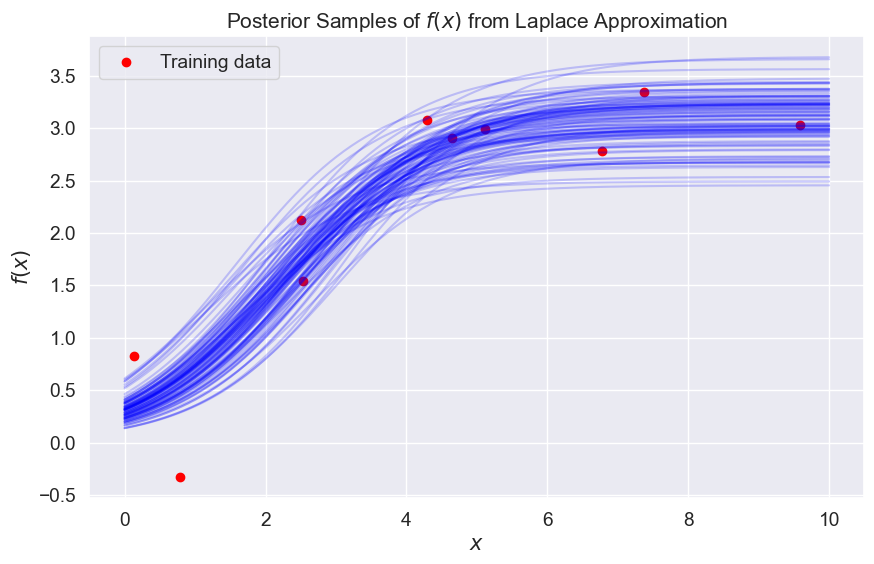

In [48]:
# Generate S = 100 samples from Laplace
key = random.PRNGKey(0)
w_samples = laplace.posterior_samples(key, 100)

# Create x range for plotting f(x)
x_plot = jnp.linspace(0, 10, 200)

# Compute f(x) for each sampled weight
fx_samples = [f(w, x_plot) for w in w_samples]

# Plot sampled functions
plt.figure(figsize=(10, 6))

# Plot each sampled function
for fx in fx_samples:
    plt.plot(x_plot, fx, color='blue', alpha=0.2)

# Scatter plot of training data
plt.scatter(X, y, color='red', label='Training data')


plt.title("Posterior Samples of $f(x)$ from Laplace Approximation")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()
plt.grid(True)
plt.show()


In [62]:
# Sample many weights from the Laplace posterior
key = random.PRNGKey(42)
w_samples = laplace.posterior_samples(key, 100000)

# Compute f(8) for each sample
x_val = 8.0
f8_samples = jnp.array([f(w, x_val) for w in w_samples])

# Estimate the probability that f(8) > 3
prob = jnp.mean(f8_samples > 3.0)
print("Approximate posterior probability that f(8) > 3:", prob)



Approximate posterior probability that f(8) > 3: 0.66129
